In [1]:
# Change the working directory
%cd ../..

/mnt/nfs/scratch1/rbialik/adversarial-recommendation-systems


In [2]:
%reload_ext autoreload
import surprise
import numpy as np
import pandas as pd
from scipy import sparse
import src.cf.experiment_core as cf_core

from src.cf.utils.timer import Timer

from src.cf.utils.constants import (
    DEFAULT_USER_COL,
    DEFAULT_ITEM_COL,
    DEFAULT_RATING_COL,
    DEFAULT_PREDICTION_COL
)

from src.cf.evaluation.eval_metrics_numba import (
    rmse,
    mae,
    precision_at_k,
    recall_at_k
)

from src.models.surprise_cf import * 
from src.models.cf_utils import * 

In [3]:
generated_users_file = '/mnt/nfs/scratch1/neerajsharma/model_params/generated_10000_user_neighbors_without_reviews_more_sparse.npy'
generated_items_file = '/mnt/nfs/scratch1/neerajsharma/model_params/generated_1000_item_neighbors_without_reviews_more_sparse.npy'
reviews_generated_users_file = '/mnt/nfs/scratch1/neerajsharma/model_params/generated_10000_user_neighbors_more_sparse.npy'
reviews_generated_items_file = '/mnt/nfs/scratch1/neerajsharma/model_params/generated_1000_item_neighbors_more_sparse.npy'

In [4]:
vanilla = True
aug = True
reviews_aug = True
cold_start = False

In [5]:
masked_R_coo, unmasked_R_coo, keep_item_idxs = cf_core.get_data_from_dataloader()
mask_coo = sparse.coo_matrix(cf_core.logical_xor(masked_R_coo, unmasked_R_coo))

nnzs = masked_R_coo.getnnz(axis=1)
warm_users = nnzs > 2

loading the data... took 7.613856859039515 seconds for loading the dataset.


In [6]:
aug_masked_R_coo, aug_unmasked_R_coo, aug_mask_coo, generated_users, generated_items = \
    make_aug_data(
        masked_R_coo, 
        unmasked_R_coo, 
        keep_item_idxs, 
        mask_coo, warm_users, 
        generated_users_file, 
        generated_items_file)
reviews_aug_masked_R_coo, reviews_aug_unmasked_R_coo, reviews_aug_mask_coo, reviews_generated_users, reviews_generated_items = \
    make_aug_data(
        masked_R_coo, 
        unmasked_R_coo, 
        keep_item_idxs, 
        mask_coo, warm_users, 
        reviews_generated_users_file, 
        reviews_generated_items_file)

In [7]:
print("\n vanilla data")
mask_csr = mask_coo.tocsr()
unmasked_vals_csr = unmasked_R_coo.multiply(mask_coo)
unmasked_vals_coo = sparse.coo_matrix(unmasked_vals_csr)
unmasked_cold_coo = cf_core.only_cold_start(masked_R_coo, unmasked_vals_coo, warm_users)
print("\n augmented data")
aug_mask_csr = aug_mask_coo.tocsr()
aug_unmasked_vals_csr = aug_unmasked_R_coo.multiply(aug_mask_coo)
aug_unmasked_vals_coo = sparse.coo_matrix(aug_unmasked_vals_csr)
aug_unmasked_cold_coo = cf_core.only_cold_start(aug_masked_R_coo, aug_unmasked_vals_coo, warm_users)
print("\n augmented (+review) data")
reviews_aug_mask_csr = reviews_aug_mask_coo.tocsr()
reviews_aug_unmasked_vals_csr = reviews_aug_unmasked_R_coo.multiply(reviews_aug_mask_coo)
reviews_aug_unmasked_vals_coo = sparse.coo_matrix(reviews_aug_unmasked_vals_csr)
reviews_aug_unmasked_cold_coo = cf_core.only_cold_start(reviews_aug_masked_R_coo, reviews_aug_unmasked_vals_coo, warm_users)


 vanilla data
num users total =  62926
num cold start users =  35946

 augmented data
num users total =  72926
num cold start users =  45946

 augmented (+review) data
num users total =  72926
num cold start users =  45946


In [8]:
if reviews_aug:
    reviews_aug_trainset, reviews_aug_testset, reviews_aug_cold_testset = setup(reviews_aug_masked_R_coo, reviews_aug_unmasked_vals_coo, reviews_aug_unmasked_cold_coo)
if aug:
    aug_trainset, aug_testset, aug_cold_testset = setup(aug_masked_R_coo, aug_unmasked_vals_coo, aug_unmasked_cold_coo)
if vanilla:
    trainset, testset, cold_testset = setup(masked_R_coo, unmasked_vals_coo, unmasked_cold_coo)

make train and test sets...done in 29 seconds
make train and test sets...done in 14 seconds
make train and test sets...done in 3 seconds


In [9]:
if vanilla:
    SVD_vanilla = Model(
        name='SVD (vanilla)', 
        algo=SVD(verbose=False), 
        ks=5, 
        ground_truth=unmasked_vals_coo, 
        mask=mask_coo, 
        ground_truth_cold=unmasked_cold_coo,
        trainset=trainset,
        testset=testset,
        cold_testset=cold_testset)
    SVD_vanilla.train()
    SVD_vanilla.get_diy_predictions()

training  SVD (vanilla) ... done in  11 seconds


In [10]:
if aug:
    SVD_aug = Model(
        name='SVD (aug)', 
        algo=SVD(verbose=False), 
        ks=5, 
        ground_truth=aug_unmasked_vals_coo, 
        mask=aug_mask_coo, 
        ground_truth_cold=aug_unmasked_cold_coo,
        trainset=aug_trainset,
        testset=aug_testset,
        cold_testset=aug_cold_testset)

    SVD_aug.train()
    SVD_aug.get_diy_predictions()
    SVD_aug.refined_predictions = refine_ratings(
        SVD_aug.trainset.ur, 
        SVD_aug.trainset.ir, 
        SVD_aug.full_prediction_matrix.copy(), 
        generated_users,
        generated_items, .3
    )

training  SVD (aug) ... done in  442 seconds
refining...done in 13 seconds


In [11]:
if reviews_aug:
    SVD_aug_reviews = Model(
        name='SVD (aug w/ reviews)', 
        algo=SVD(verbose=False), 
        ks=5, 
        ground_truth=reviews_aug_unmasked_vals_coo, 
        mask=reviews_aug_mask_coo, 
        ground_truth_cold=reviews_aug_unmasked_cold_coo,
        trainset=reviews_aug_trainset,
        testset=reviews_aug_testset,
        cold_testset=reviews_aug_cold_testset)
        
    SVD_aug_reviews.train()
    SVD_aug_reviews.get_diy_predictions()
    SVD_aug_reviews.refined_predictions = refine_ratings(
        SVD_aug_reviews.trainset.ur, 
        SVD_aug_reviews.trainset.ir, 
        SVD_aug_reviews.full_prediction_matrix.copy(), 
        reviews_generated_users,
        reviews_generated_items, .3
    )

training  SVD (aug w/ reviews) ... done in  1008 seconds
refining...done in 13 seconds


In [12]:
def pad(mask, ground_truth):
    og_rows, og_cols = mask.shape
    aug_rows, aug_cols = ground_truth.shape
    return np.pad(mask, ((0, aug_rows-og_rows), (0, aug_cols-og_cols)), 'constant', constant_values=0)

In [13]:
models = []
if vanilla:
    models.append(SVD_vanilla)
if aug:
    models.append(SVD_aug)
if reviews_aug:
    models.append(SVD_aug_reviews)

for i, model in enumerate(models):
    print(model.name)
    ground_truth = model.ground_truth.toarray()
    mask = mask_coo.toarray()
    if cold_start:
        mask_coo.toarray()[(nnzs < 3)] = [0] * mask.shape[1]
    mask = pad(mask, ground_truth)
    ground_truth *= mask
    if 'aug' in model.name:
        model.refined_rmse = rmse(ground_truth, model.refined_predictions)
        model.refined_mae = mae(ground_truth, model.refined_predictions)
    model.rmse = rmse(ground_truth, model.full_prediction_matrix)
    model.mae = mae(ground_truth, model.full_prediction_matrix)
    models[i] = model

SVD (vanilla)
/mnt/nfs/scratch1/rbialik/adversarial-recommendation-systems/src/cf/evaluation/eval_metrics_numba.py:32: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  pred = getitem_by_row_col(rating_pred, true_uid, true_iid)
SVD (aug)
SVD (aug w/ reviews)


In [61]:
labels = []
errors = []
for model in models:
    labels.append(model.name)
    errors.append([model.mae, model.rmse])
    if 'aug' in model.name:
        labels.append(model.name + ' refined')
        errors.append([model.refined_mae, model.refined_rmse])
user_type = 'all users' if not cold_start else 'cold start'
error_labels = [user_type] + ['MAE', 'RMSE']
tab_data = [[labels[i]] + errors[i] for i in range(len(labels))]
print(tabulate(tab_data, headers=error_labels, tablefmt="github"))


name = user_type.replace(' ', '_')
results_loc = f'results/10k/{name}'
os.makedirs(results_loc, exist_ok=True)
f = open(results_loc + '/errors.txt', "w")
f.write(tabulate(tab_data, headers=error_labels, tablefmt="latex"))


| cold start                   |      MAE |    RMSE |
|------------------------------|----------|---------|
| SVD (vanilla)                | 0.7401   | 1.02161 |
| SVD (aug)                    | 0.8237   | 1.11696 |
| SVD (aug) refined            | 0.888063 | 1.23267 |
| SVD (aug w/ reviews)         | 0.80158  | 1.13561 |
| SVD (aug w/ reviews) refined | 0.863817 | 1.24209 |


379

In [29]:
for i, model in enumerate(models):
    if 'aug' not in model.name:
        trainset_df = cf_core.surprise_trainset_to_df(model.trainset)
        model.trainset_uid, model.trainset_iid = trainset_df['userID'].to_numpy(), trainset_df['itemID'].to_numpy()
    elif 'reviews' in model.name:
        reviews_aug_trainset_df = cf_core.surprise_trainset_to_df(reviews_aug_trainset)
        model.trainset_uid, model.trainset_iid = reviews_aug_trainset_df['userID'].to_numpy(), reviews_aug_trainset_df['itemID'].to_numpy()
    else:
        aug_trainset_df = cf_core.surprise_trainset_to_df(aug_trainset)
        model.trainset_uid, model.trainset_iid = aug_trainset_df['userID'].to_numpy(), aug_trainset_df['itemID'].to_numpy()
    models[i] = model

In [16]:
for i, model in enumerate(models):
    model.precisions = []
    model.recalls = []
    model.refined_precisions = []
    model.refined_recalls =[]
    ground_truth = model.ground_truth.toarray()
    mask = mask_coo.toarray() 
    if cold_start:
        mask_coo.toarray()[(nnzs < 3)] = [0] * mask.shape[1]
    mask = pad(mask, ground_truth)
    ground_truth *= mask
    for k in range(1,16):
        model.precisions.append(precision_at_k(
            ground_truth, 
            model.full_prediction_matrix, 
            model.trainset_uid, 
            model.trainset_iid,
            relevancy_method='top_k', 
            k=k, 
            threshold=0
        ))
        model.recalls.append(recall_at_k(
            ground_truth, 
            model.full_prediction_matrix, 
            model.trainset_uid, 
            model.trainset_iid,
            relevancy_method='top_k', 
            k=k, 
            threshold=0
        ))
        if 'aug' in model.name:
            model.refined_precisions.append(precision_at_k(
                ground_truth, 
                model.refined_predictions, 
                model.trainset_uid, 
                model.trainset_iid,
                relevancy_method='top_k', 
                k=k, 
                threshold=0
            ))
            model.refined_recalls.append(recall_at_k(
                ground_truth, 
                model.refined_predictions, 
                model.trainset_uid, 
                model.trainset_iid,
                relevancy_method='top_k', 
                k=k, 
                threshold=0
            ))
    models[i] = model

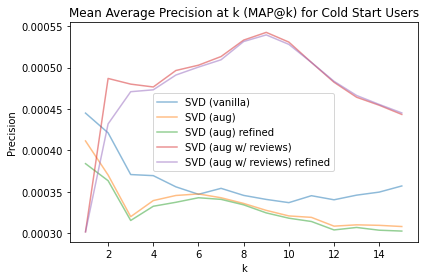

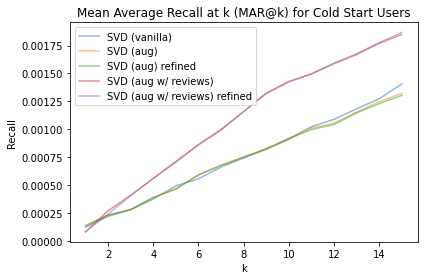

In [62]:
import os
MAPs = []
MARs = []
labels = []
for model in models:
    labels.append(model.name)
    MAPs.append(model.precisions)
    MARs.append(model.recalls)
    if 'aug' in model.name:
        labels.append(model.name + ' refined')
        MAPs.append(model.refined_precisions)
        MARs.append(model.refined_recalls)

ks = list(range(1, 16))
for i in range(len(labels)):
    plt.plot(ks, MAPs[i], label=labels[i], alpha=.5)

plt.title(f'Mean Average Precision at k (MAP@k) for {user_type.title()} Users')
plt.xlabel('k')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(results_loc + '/precision.png', facecolor='white')
plt.show()


ks = list(range(1, 16))
for i in range(len(labels)):
    plt.plot(ks, MARs[i], label=labels[i], alpha=.5)

plt.title(f'Mean Average Recall at k (MAR@k) for {user_type.title()} Users')
plt.xlabel('k')
plt.ylabel('Recall')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(results_loc + '/recall.png', facecolor='white')
plt.show()